In [1]:
import os
os.environ["XUVTOP"] = "/usr/local/ssw/packages/chianti/dbase/"
from scipy.io import readsav
import xarray as xr
import numpy as np
from dateutil.tz import gettz
from datetime import datetime
from datetime import date
import dask, pdb
from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
from matplotlib import colors

from muse.synthesis.synthesis import vdem_synthesis, vdem_syn_join_slits_wvl, ph2e, exposure_time
from muse.instr.psf import  convolve_model_psf, oversampled_wavelength_to_sg
from muse.instr.gausslobes import gausslobes
from muse.instr.detect_sidelobes import remove_yx_sidelobes
from muse.instr.utils import create_eff_area_xarray, ci2sg_response_format
from muse.instr import mono_diffraction
from muse.transforms.transforms import reshape_x2rs
from muse.utils.utils import  deweight_func, sub_contaminants, read_response, weight_func
from muse.instr.utils import sum_lines_per_band, sum_lines_slits_per_band
from muse.inversions.inversions import vdem_solve

from muse.utils.fitting import masker
from muse.variables import CENTROID_UNCERT_PROMISED, EXP_NOM
from muse.utils.fitting import gaussian_fitting_analysis,calculate_moments_gaussian
from muse.utils.fitting import main_gaussian_fitter,_vet_new_local_max,fit_gaussian
from muse.utils.fitting import fit_gaussian_remove_badspec,local_max
from muse.utils.miscellaneous import plot_gfat2c, generate_outliers_newer, get_outliers_newer, plot_with_chisquare

from sklearn.linear_model import Ridge as Ridge
from sklearn.linear_model import LassoLars as LassoLars
author="JMS"

In [3]:
data_path = '/home/ec2-user/SageMaker/data/565000/'
response= xr.open_zarr(data_path + 'response_565000.zarr').compute()
response["line"] = ['Fe XIX', 'Fe XXI', '108 missing main line', 'Fe IX',
                    '171 missing main line', 'Fe XV', '284 missing main line']

if False:
    spec_gt = xr.open_zarr(data_path+'spec_m-flare-muram_los2_trac_565000_core.zarr').compute()
    spec_gt["flux"].attrs = dict(units="ph / s")
    spec_gt["gain"] = xr.DataArray([10]*3, dims=['band'])
    spec_obs = sum_lines_slits_per_band(spec_gt)
    spec_obs.to_zarr(data_path+'spec_obs.zarr', mode='w')
    
    spec_gt_70lpi = xr.open_zarr(data_path+'spec_m-flare-muram_los2_trac_565000_70LPI.zarr').compute()
    # except 284 band, no diffraction patterns
    spec_gt_70lpi["flux"].attrs = dict(units="ph / s")
    spec_gt_70lpi["gain"] = xr.DataArray([10]*3, dims=['band'])
    spec_obs_70lpi = sum_lines_slits_per_band(spec_gt_70lpi)
    spec_obs_70lpi.to_zarr(data_path+'spec_obs_70lpi.zarr', mode='w')
else:
    spec_obs = xr.open_zarr(data_path+'spec_obs.zarr').compute()
    spec_obs_70lpi = xr.open_zarr(data_path+'spec_obs_70lpi.zarr').compute()

In [4]:
norm = colors.PowerNorm(0.3, 0, 1e4)
npix = 2
velocity_range = 400
line = ['Fe XV']

In [5]:
mono_obs = mono_diffraction.mono_image(spec_obs, response)
mono_obs_70lpi = mono_diffraction.mono_image(spec_obs_70lpi, response)

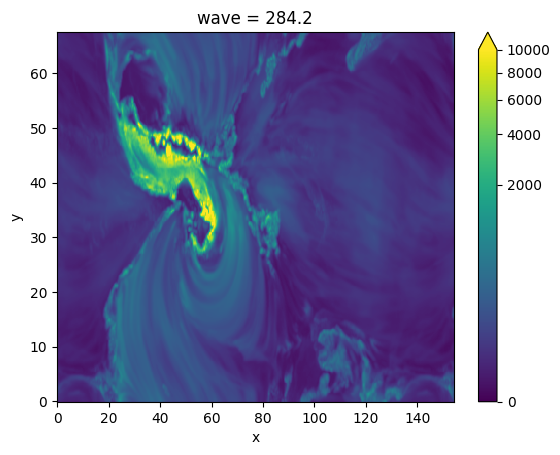

In [6]:
mono_obs.plot(norm=norm)

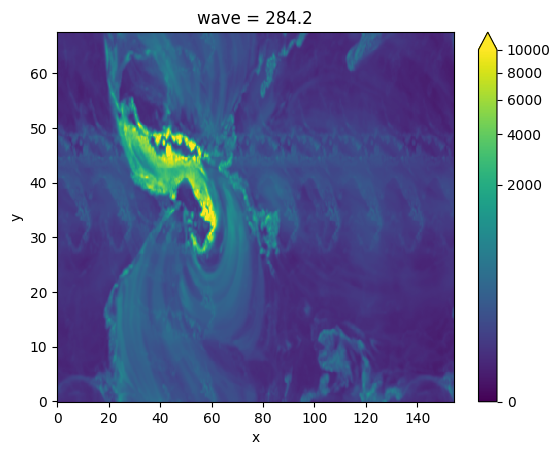

In [7]:
mono_obs_70lpi.plot(norm=norm)

In [9]:
import astropy.units as u
import numpy as np
from scipy.ndimage import rotate as rotate

__all__ = ["gausslobes"]


@u.quantity_input
def gausslobes(
    *,
    wavelength: u.AA = 284 * u.AA,
    center=True,
    no_core=False,
    only_core=False,
    fwhm=0.4,
    lpi=70,
    nslits=35,
    nsteps=11,
    oversample_x=7,
    oversample_y=3,
    slit_dim=1024,
    spike_values=None,
    transmission=0.81,
    xpix_scale=0.4,
    ypix_scale=0.167,
    cut_in_half=False,
    axis=None,
    angle=None,
    no_psf=False
):
    """
    Creates the Gausslobe pattern.

    By default, all value default to the MUSE specification,
    i.e., 0.4" x 0.167" pixels.

    Parameters
    ----------
    wavelength : `u.Quantity`
        Wavelength in Angstroms (or equivalent).
        Defaults to 284 Angstroms.
    center : `bool`
        Option to center the pattern, by default `False`.
    no_core : `bool`
        Option to subtract out core lobe, by default `False`
    fwhm : `float`
        FWHM in arcsec, by default 0.4.
    lpi : `int`
        Lines per inch of the mesh grid, by default 70.
    nslits : `int`
        Number of slits, by default 35.
    nsteps : `int`
        Number of steps in one raster, by default 35.
    oversample_x : `int`
        Over sample factor for x pixels, by default 7.
    oversample_y : `int`
        Over sample factor for y pixels, by default 3.
    slit_dim :  `int`
        Number of along-slit pixels, i.e., y-axis size, by default 1024.
    spike_values : `numpy.array`
        Lobe intensities below taken from FFT of quarter circle aperture with given LPI mesh.
        Note variation of lobe-to-core intensities with wavelength could be added,
        though not a big effect within  current bandpass.
        By default `None`.
    transmission : `float`
        Mesh transmission, by default 0.81.
    xpix_scale : `float`
        Pixel size in x-axis in arcsec, by default 0.4. JMS this should be 0.44. I didnt change because of the tests
    ypix_scale : `float`
        Pixel size in y-axis in arcsec, by default 0.167.
    axis : {'None' | 'x' | 'y'}, optional
        Along specific direction only, by default `None`.
        Which means both x and y directions

    Returns
    -------
    `numpy.ndarray`
        The Gausslobe pattern.

    Reference
    ---------
    This is a Python version of the original code from `Adrian.Daw <adrian.daw@nasa.gov>`__.
    IDL code version dated - 24 Oct 2022.
    """
    coverage = nslits * nsteps
    ny = 2 * slit_dim + 1
    noy = ny * oversample_y
    nx = 2 * coverage + 1
    nox = nx * oversample_x
    midy = int(noy / 2)
    midx = int(nox / 2)
    sigma = fwhm / 2.35482
    if no_psf: sigma = 1e-1
    y = ypix_scale / oversample_y * (np.arange(noy) - midy)
    x = xpix_scale / oversample_x * (np.arange(nox) - midx)
    spacing = (wavelength.to(u.m).value / (0.0254 / lpi)) / (1 * u.arcsec).to(u.rad).value
    if not spike_values:
        # Number of side lobes that fit within the CCD.
        number_spikes = int(np.max([slit_dim * ypix_scale, coverage * xpix_scale]) / spacing)
        sin_arg = (np.arange(number_spikes) + 1) * np.pi * np.sqrt(transmission)
        spike_values = np.append(1, np.sin(sin_arg) / sin_arg) ** 2
    else:
        number_spikes = len(spike_values)
    # Calculate two 1D Gaussian profiles.
    gx = np.zeros(int(nox))
    gy = np.zeros(int(noy))
    for i in range(-number_spikes, number_spikes + 1):
        gx = gx + spike_values[abs(i)] * np.exp(-(((x - spacing * i) / sigma) ** 2) / 2)
        gy = gy + spike_values[abs(i)] * np.exp(-(((y - spacing * i) / sigma) ** 2) / 2)
    ytrim = int(spacing / 2 / ypix_scale)
    xtrim = int(spacing / 2 / xpix_scale)
    if xtrim == 0:
        xtrim = 1
    if axis == "x":
        mesh_psf = gx.reshape(nx, oversample_x).sum(axis=1)
        core_total = mesh_psf[coverage - xtrim : coverage + xtrim]
        return transmission * mesh_psf / np.sum(core_total)
    if axis == "y":
        mesh_psf = gy.reshape(ny, oversample_y).sum(axis=1)
        core_total = mesh_psf[slit_dim - ytrim : slit_dim + ytrim]
        return transmission * mesh_psf / np.sum(core_total)
    # Construct 2D PSF as "2 x 1D"
    mesh_psf = gx[:, np.newaxis] * gy[np.newaxis, :]
    if angle is not None:
        mesh_psf_rot = rotate(mesh_psf, angle=angle)
        nx_rot, ny_rot = np.shape(mesh_psf_rot)
        mesh_psf_rot_temp = np.zeros_like(mesh_psf)
        if ny_rot < noy and nx_rot > nox:
            mesh_psf_rot_temp[:, int(noy / 2) - int(ny_rot / 2) : int(noy / 2) - int(ny_rot / 2) + ny_rot] = mesh_psf_rot[
                int(nx_rot / 2) - int(nox / 2) : int(nx_rot / 2) - int(nox / 2) + nox, :
            ]
        elif ny_rot < noy and nx_rot < nox:
            mesh_psf_rot_temp[
                int(nox / 2) - int(nx_rot / 2) : int(nox / 2) - int(nx_rot / 2 + nx_rot),
                int(ny_rot / 2) - int(noy / 2) : int(ny_rot / 2) - int(noy / 2) + noy,
            ] = mesh_psf_rot
        elif ny_rot > noy and nx_rot < nox:
            mesh_psf_rot_temp[int(nox / 2) - int(nx_rot / 2) : int(nox / 2) - int(nx_rot / 2) + nx_rot, :] = mesh_psf_rot[
                :, int(ny_rot / 2) - int(noy / 2) : int(ny_rot / 2) - int(noy / 2) + noy
            ]
        else:
            mesh_psf_rot_temp = mesh_psf_rot[
                int(nx_rot / 2) - int(nox / 2) : int(nx_rot / 2) - int(nox / 2) + nox,
                int(ny_rot / 2) - int(noy / 2) : int(ny_rot / 2) - int(noy / 2) + noy,
            ]

        mesh_psf = mesh_psf_rot_temp
    mesh_psf = mesh_psf.reshape(nx, oversample_x, ny, oversample_y).sum(axis=(1, 3))
    core_total = mesh_psf[coverage - xtrim : coverage + xtrim, slit_dim - ytrim : slit_dim + ytrim]
    # Normalize so central core is T^2.
    mesh_psf = transmission**2 * mesh_psf / np.sum(core_total)
    if no_core:
        mesh_psf[coverage - xtrim : coverage + xtrim, slit_dim - ytrim : slit_dim + ytrim] = 0
    elif only_core:
        mesh_psf[...] = 0.0
        mesh_psf[coverage - xtrim : coverage + xtrim, slit_dim - ytrim : slit_dim + ytrim] = (
            transmission**2 * core_total / np.sum(core_total)
        )

    if not center:
        mesh_psf = np.roll(
            np.roll(mesh_psf, mesh_psf.shape[1] // 2, axis=1),
            mesh_psf.shape[0] // 2,
            axis=0,
        )
    if cut_in_half:
        mesh_psf = mesh_psf[: int(nx / 2), :]
    # pdb.set_trace()
    return mesh_psf


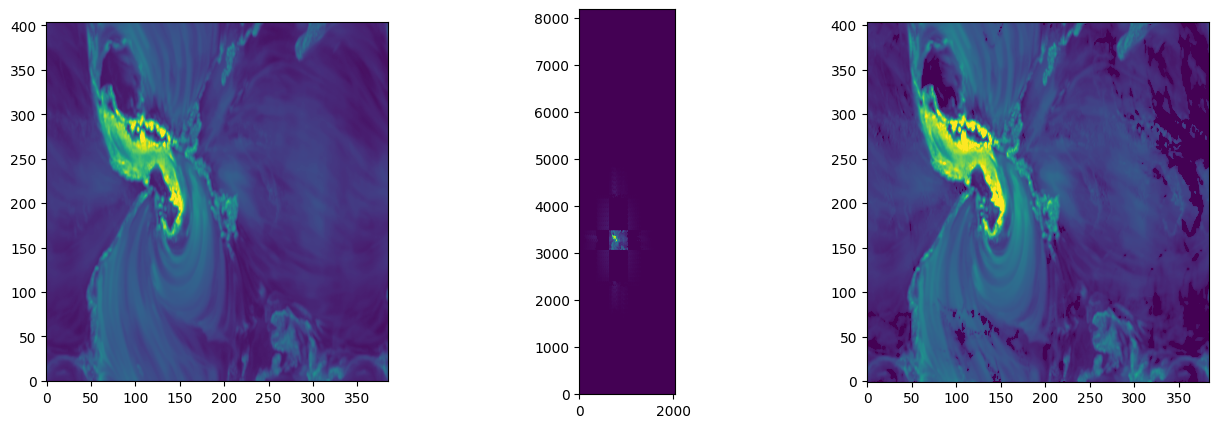

In [10]:
from skimage import restoration
from scipy import signal, fftpack
from muse.instr.detect_sidelobes import gl_dist, gl_peak

def deconvolve0(star, psf):
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return np.real(fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft))))

def deconvolve(img, psf):
    imgy, imgx = img.shape
    psfy, psfx = psf.shape
    ny = 2**(max(np.ceil(np.log2(imgy))+1, np.ceil(np.log2(psfy))+1)).astype(int)
    nx = 2**(max(np.ceil(np.log2(imgx))+1, np.ceil(np.log2(psfx))+1)).astype(int)
    img0 = np.zeros((ny, nx))
    img0[:imgy, :imgx] = img
    psf0 = np.zeros((ny, nx))
    psf0[:psfy, :psfx] = psf
    img0_fft = fftpack.fftshift(fftpack.fftn(img0))
    psf0_fft = fftpack.fftshift(fftpack.fftn(psf0))
    res = np.real(fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(img0_fft/psf0_fft))))
    # res = restoration.richardson_lucy(img0, psf0, num_iter=30,clip=True,filter_epsilon=1e-3)
    cenx = 0.5*(nx-1)
    ceny = 0.5*(ny-1)
    return res
    # return res[int(ceny-imgy//2):int(ceny+imgy//2), \
    #            int(cenx-imgx//2):int(cenx+imgx//2)]
    
gl = gausslobes(no_psf=True).T
img = mono_obs_70lpi.isel(wave=0).data
img0 = mono_obs.isel(wave=0).data
# img = img[:, :-1]
# img = np.where(img < 0, 0, img)
ys, xs = img.shape
ceny, cenx = gl.shape[0]//2, gl.shape[1]//2
gl2 = gl[ceny-ys//2:ceny+ys//2, cenx-xs//2:cenx+xs//2]

nimg = signal.fftconvolve(img0, gl)
after = deconvolve(img, gl)
after0 = deconvolve0(img[:, :-1], gl2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img0, norm=norm)
ax[1].imshow(after, norm=norm)
ax[2].imshow(after0, norm=norm)
# ax[2].imshow(after-img0, vmin=-1e3, vmax=1e3, cmap='bwr')


In [181]:
from scipy import signal, fftpack

img = mono_obs_70lpi.isel(wave=0).data
img0 = mono_obs.isel(wave=0).data

psf = gausslobes().T
imgy, imgx = img.shape
psfy, psfx = psf.shape
ny = imgy + psfy -1
nx = imgx + psfx -1
img_ = np.zeros((ny, nx))
img_[:imgy, :imgx] = img
psf_ = np.zeros((ny, nx))
psf_[:psfy, :psfx] = psf
img__fft = fftpack.fftshift(fftpack.fftn(img_))
psf__fft = fftpack.fftshift(fftpack.fftn(psf_))
res = np.real(fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(img__fft/psf__fft))))
# res = restoration.richardson_lucy(img0, psf0, num_iter=30,clip=True,filter_epsilon=1e-3)
cenx = 0.5*(nx-1)
ceny = 0.5*(ny-1)
no_core_psf = res[(ny-psfy+1)//2:(ny-psfy+1)//2+imgy, (nx-psfx+1)//2:(nx-psfx+1)//2+imgx]

gl_core = gausslobes(only_core=True).T
with_core_psf = signal.fftconvolve(no_core_psf, gl_core)
ymar = (gl_core.shape[0])//2
xmar = (gl_core.shape[1])//2
with_core_psf_part = nimg[psfy//2:psfy//2+imgy, psfx//2:psfx//2+imgx]



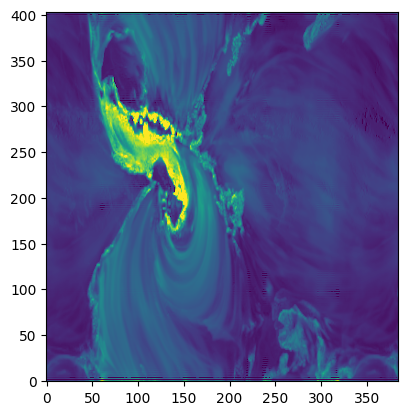

In [182]:
plt.imshow(dum, norm=norm)

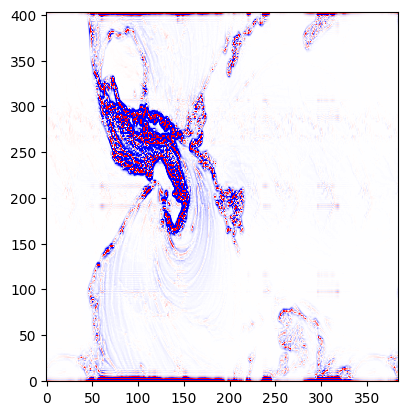

In [183]:
plt.imshow(dum*0.64-img0, vmin=-1e2, vmax=1e2, cmap='bwr')

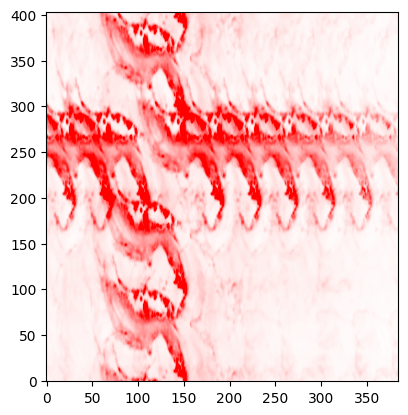

In [184]:
plt.imshow(img-img0, vmin=-1e2, vmax=1e2, cmap='bwr')

In [185]:
gl_core = gausslobes(only_core=True).T
nimg = signal.fftconvolve(dum, gl_core)
ymar = (gl_core.shape[0])//2
xmar = (gl_core.shape[1])//2
dum2 = nimg[ymar:ymar+imgy, xmar:xmar+imgx]

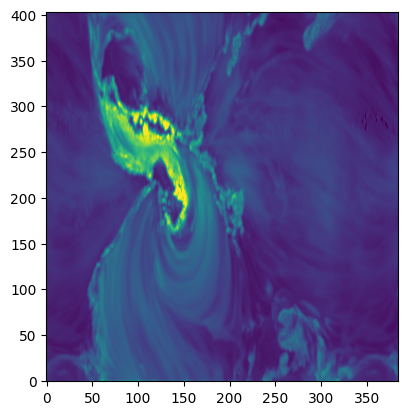

In [186]:
plt.imshow(dum2, norm=norm)

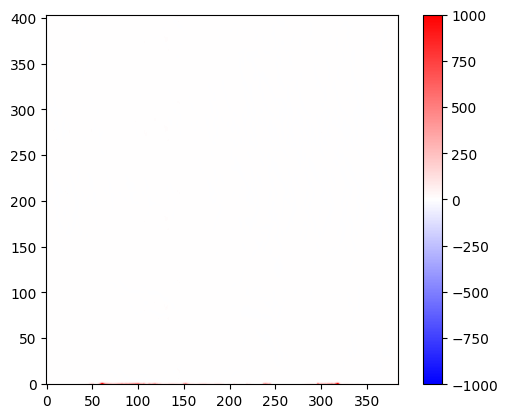

In [188]:
plt.imshow(dum2-img0, vmin=-1e3, vmax=1e3, cmap='bwr')
plt.colorbar()

In [20]:
imgy, imgx = img.shape
psfy, psfx = gl2.shape#, res.shape

In [24]:
np.ceil(np.log2(imgy))+1

10.0

In [16]:
img11 = np.zeros([2**10, 2**10])
img11[:404, :385] = img
gl11 = np.zeros([2**10, 2**10])
gl11[:404, :384] = gl2

In [18]:
after = deconvolve(img11, gl11)


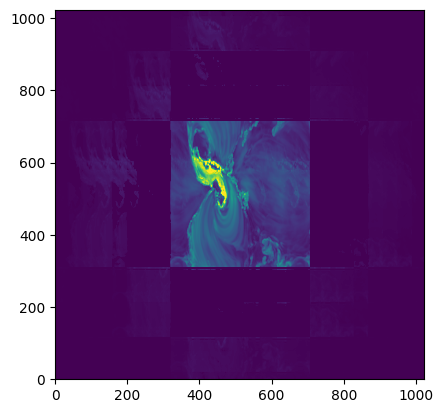

In [19]:
plt.imshow(after, norm=norm)

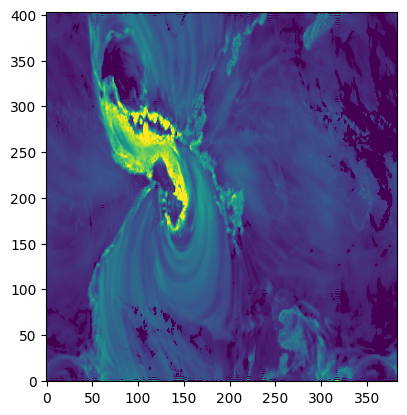

In [10]:
from scipy import fftpack



res = deconvolve(img, gl2)
plt.imshow(res, norm=norm)

(404, 193) (404, 385)


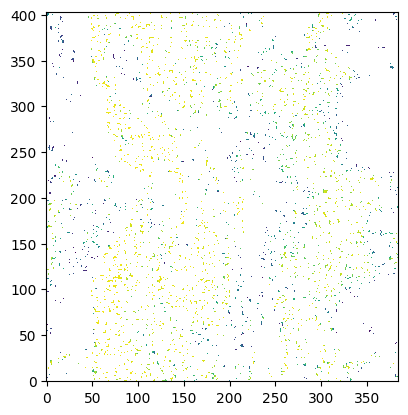

In [75]:
def deconvolve(img, psf, iterations=1000, clip_negative=True):
    # TODO: do we need a check to make sure this is a full-frame image?
    if clip_negative:
        img = np.where(img < 0, 0, img)
    # Center PSF at pixel (0,0)
    psf = np.roll(np.roll(psf, psf.shape[0] // 2, axis=0), psf.shape[1] // 2, axis=1)
    # Convolution requires FFT of the PSF
    psf = np.fft.rfft2(psf)
    psf_conj = psf.conj()
    img_decon = np.copy(img)
    for _ in range(iterations):
        crop_factor = slice(0,-1)
        ratio = img[:,crop_factor] / np.fft.irfft2(np.fft.rfft2(img_decon) * psf)
        img_decon[:,crop_factor] = img_decon[:,crop_factor] * np.fft.irfft2(np.fft.rfft2(ratio) * psf_conj)
    return img_decon
    
#res = restoration.richardson_lucy(nimg, gl2, num_iter=500,clip=True,filter_epsilon=1e-3)
res = deconvolve(nimg,gl2)
plt.imshow(res)


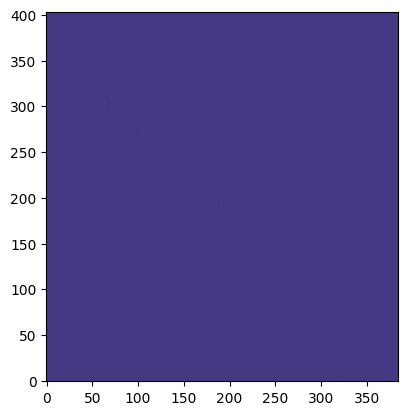

In [76]:
plt.imshow(res)

In [73]:
import pdb; pdb.pm()

> /tmp/ipykernel_17172/3228192115.py(18)deconvolve()
     16         else:
     17             crop_factor = slice(0,None)
---> 18         ratio = img[:,crop_factor] / np.fft.irfft2(np.fft.rfft2(img_decon) * psf)
     19         img_decon = img_decon[:,crop_factor] * np.fft.irfft2(np.fft.rfft2(ratio) * psf_conj)
     20 



ipdb>  
ipdb>  img[:,crop_factor].shape


(404, 385)


ipdb>  _


1


ipdb>  q


In [137]:
from skimage import restoration
import copy
gl = gausslobes().T+1e-30
ys, xs = mono_obs.squeeze().shape
im2 = copy.deepcopy(gl)*0
im2[:ys, :xs] = mono_obs_70lpi.isel(wave=0).data
im2 = np.roll(im2, (np.array(im2.shape)-np.array([ys, xs]))//2, axis=(0, 1))
res = restoration.richardson_lucy(im2, gl, num_iter=10)

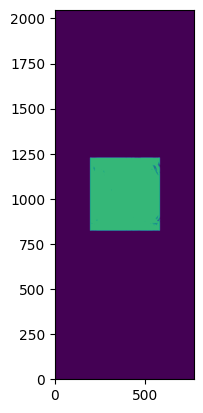

In [138]:
res1 = res[:ys, :xs]
plt.imshow(res, vmin=0, vmax=1.5)

In [119]:
res1.max()

1.0

In [120]:
res1.min()

0.19032852412959664

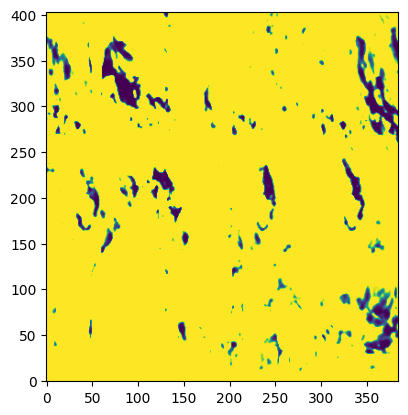

In [142]:
from skimage import restoration
gl = gausslobes()
ys, xs = mono_obs.squeeze().shape
cenx, ceny = gl.shape[0]//2, gl.shape[1]//2
gl2 = gl[cenx-xs//2:cenx+xs//2, ceny-ys//2:ceny+ys//2+1]

res = restoration.richardson_lucy(mono_obs_70lpi.isel(wave=0), gl, num_iter=10)
plt.imshow(res)

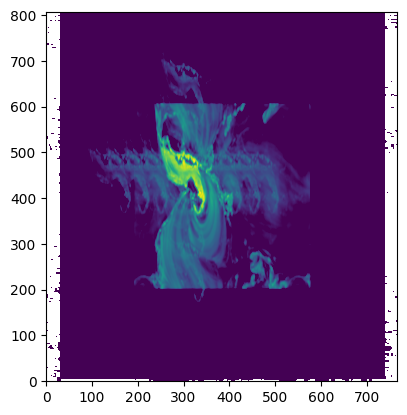

In [109]:
from scipy.signal import convolve
dum = mono_obs.isel(wave=0)
dum1 = convolve(dum, gl2)
plt.imshow(np.log10(dum1), vmin=1, vmax=4)

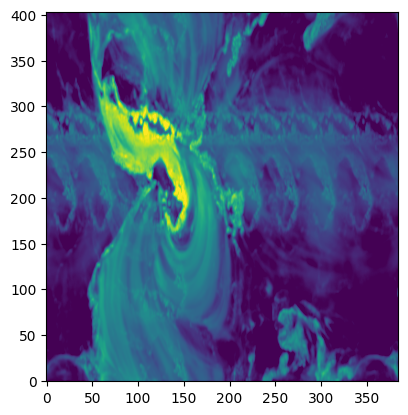

In [108]:
plt.imshow(np.log10(mono_obs_70lpi.isel(wave=0)), vmin=1, vmax=4)

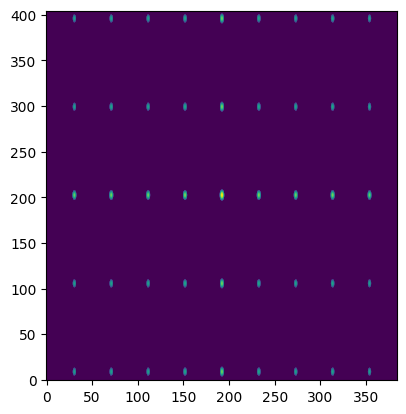

In [88]:
plt.imshow(np.log10(gl2+1e-30), vmin=-10, vmax=-1)

In [90]:
res.min()

1.4455641240191679e-13